In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm

# custom libs
import sys
sys.path.append("../")
from src.transformations import (
                            obtain_densities, 
                            mLQDT,
                            obtain_densities_from_lqd
                            )
from src.dynamicFPC import K_dFPC, W_dFPC
from src.forecasting import dynamics_forecaster, run_forecaster, train_test_split, overall_measures, expanding_window_cv
from src.preprocessing import align_densities

In [4]:
# Dados
data_path = "../data/processed/"
returns_path = ''.join([data_path, 'ibovespa_treated.xlsx'])
df = pd.read_excel(returns_path, index_col="time")
df.head()

,2024-12-02,2024-12-03,2024-12-04,2024-12-05,2024-12-06,2024-12-09,2024-12-10,2024-12-11,2024-12-12,2024-12-13,...,2025-11-14,2025-11-17,2025-11-18,2025-11-19,2025-11-21,2025-11-24,2025-11-25,2025-11-26,2025-11-27,2025-11-28
time,,,,,,,,,,,,,,,,,,,,,
10:00:00,0.000011,-0.000372,-0.000035,0.007233,-0.001305,-0.000459,0.002388,0.002212,-0.008001,-0.000824,...,-0.000957,-0.002307,-0.003734,-0.005020,-0.001139,-0.000255,0.002339,0.004176,-0.000224,-0.000238
10:05:00,-0.002271,0.003372,0.001716,0.005538,0.000069,0.006429,0.002343,0.001918,-0.007582,-0.000413,...,-0.001522,0.000739,-0.000613,0.000306,-0.002021,-0.000810,0.001557,-0.001565,-0.000193,0.002906
10:10:00,-0.000582,0.002832,-0.000502,0.000739,0.000261,0.001891,0.000775,-0.001172,0.000216,-0.000432,...,0.000360,-0.000105,-0.000159,-0.000362,0.000092,0.001131,0.001170,0.000202,0.000556,0.000475
10:15:00,-0.001997,0.001091,0.000111,-0.000192,0.000407,-0.001392,-0.000477,-0.001526,0.000198,-0.001821,...,0.001121,-0.000284,0.003272,-0.001107,-0.001012,-0.000174,0.001002,0.001815,-0.000168,0.000973
10:20:00,-0.000037,-0.000505,-0.000327,-0.000580,-0.000436,-0.000405,0.001263,0.000676,-0.002667,0.001033,...,0.000449,0.000335,0.000853,0.000981,-0.000057,-0.000096,0.000832,0.001951,0.001060,-0.001004


In [5]:
# Obtém objetos functionais
M=3000 
df_densities_supports, df_densities = obtain_densities(df, M=M)
df_densities.head()

,2024-12-02,2024-12-03,2024-12-04,2024-12-05,2024-12-06,2024-12-09,2024-12-10,2024-12-11,2024-12-12,2024-12-13,...,2025-11-14,2025-11-17,2025-11-18,2025-11-19,2025-11-21,2025-11-24,2025-11-25,2025-11-26,2025-11-27,2025-11-28
0,26.484908,26.956133,43.192058,125.280911,22.281346,38.967352,16.381520,14.790396,14.755901,68.336475,...,56.055614,22.715586,14.822458,15.843866,32.781883,18.742967,33.634914,25.011205,59.591366,35.178493
1,26.549913,26.973634,43.381074,126.228831,22.328213,39.236235,16.389919,14.873119,14.785411,68.447117,...,56.269242,22.760257,14.822055,15.843451,32.878703,18.745446,33.688952,25.117131,59.739446,35.313673
2,26.614794,26.990503,43.570813,127.181415,22.375076,39.506838,16.398066,14.956030,14.814484,68.557193,...,56.483268,22.804829,14.820845,15.842209,32.975476,18.747281,33.742663,25.223321,59.886899,35.448818
3,26.679553,27.006743,43.761277,128.138661,22.421938,39.779179,16.405963,15.039127,14.843118,68.666702,...,56.697690,22.849304,14.818828,15.840138,33.072200,18.748473,33.796047,25.329778,60.033721,35.583923
4,26.744189,27.022353,43.952468,129.100567,22.468800,40.053275,16.413611,15.122411,14.871311,68.775642,...,56.912509,22.893683,14.816005,15.837239,33.168874,18.749022,33.849104,25.436506,60.179908,35.718987


# Multistep OOS forecast

In [6]:
horizon = 10

In [7]:
Y_train_support, Y_train, Y_test_support, Y_test = train_test_split(
                                                                df_densities, 
                                                                df_densities_supports,
                                                                train_size=horizon)
Y_train.head()

,2024-12-02,2024-12-03,2024-12-04,2024-12-05,2024-12-06,2024-12-09,2024-12-10,2024-12-11,2024-12-12,2024-12-13,...,2025-10-31,2025-11-03,2025-11-04,2025-11-05,2025-11-06,2025-11-07,2025-11-10,2025-11-11,2025-11-12,2025-11-13
0,26.484908,26.956133,43.192058,125.280911,22.281346,38.967352,16.381520,14.790396,14.755901,68.336475,...,25.621428,29.783933,98.419280,69.424565,96.754538,17.241096,50.414577,20.713828,18.734785,15.815970
1,26.549913,26.973634,43.381074,126.228831,22.328213,39.236235,16.389919,14.873119,14.785411,68.447117,...,25.722080,29.857849,98.664954,69.668475,97.272914,17.244970,50.838312,20.795376,18.735085,15.854511
2,26.614794,26.990503,43.570813,127.181415,22.375076,39.506838,16.398066,14.956030,14.814484,68.557193,...,25.823099,29.931416,98.909967,69.912666,97.792697,17.248490,51.265290,20.876871,18.735001,15.892963
3,26.679553,27.006743,43.761277,128.138661,22.421938,39.779179,16.405963,15.039127,14.843118,68.666702,...,25.924495,30.004633,99.154315,70.157137,98.313889,17.251657,51.695529,20.958314,18.734530,15.931329
4,26.744189,27.022353,43.952468,129.100567,22.468800,40.053275,16.413611,15.122411,14.871311,68.775642,...,26.026276,30.077497,99.397992,70.401886,98.836493,17.254473,52.129048,21.039706,18.733674,15.969608


In [8]:
bovespa_mLQDT = mLQDT(
                    Y_train,
                    Y_train_support
                )
bovespa_mLQDT.densities_to_lqdensities(verbose=False)
df_lqds = bovespa_mLQDT.lqd

In [9]:
WdFPC_kwargs = {
    "wavelet": 'db2',
    "N": 3,
    "p": 5,
    "d": 2,
    "nt": M,
}

WdFPC_model = W_dFPC(df_lqds.values)
WdFPC_model.fit(**WdFPC_kwargs)
w_scores = WdFPC_model.scores.real.T

c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:613: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, m] = pywt.waverec(coeffs_m, wavelet)
c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:621: ComplexWarning: Casting complex values to real discards the imaginary part
  Yhat[:, t] = mu_hat + H @ scores[:, t]


In [10]:
KdFPC_kwargs = {
    "lag_max": 5,
    "alpha": 0.10,
    "du": 0.05,
    "B": 1000,
    "p": 5,
    "m": M,
    "u": bovespa_mLQDT.lqd_support,
    "select_ncomp": False,
    "dimension": 2
}

KdFPC_model = K_dFPC(df_lqds.values)
KdFPC_model.fit(**KdFPC_kwargs)
k_scores = KdFPC_model.etahat.real.T

In [11]:
maxlags_  = 10
criteria_ = 'bic'

k_etahat_fc = run_forecaster(k_scores, maxlags_, criteria_, horizon)
w_etahat_fc = run_forecaster(w_scores, maxlags_, criteria_, horizon)

In [12]:
model = pm.auto_arima(
    bovespa_mLQDT.c,                         # univariate series
    seasonal=False,            # True if SARIMA
    trace=True,                # show the tried models
    error_action='ignore',     # ignore non-invertible models
    suppress_warnings=True,
     information_criterion='bic'
)

# Forecast h steps ahead
c_forecast, conf_int = model.predict(n_periods=horizon, return_conf_int=True)

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=353.206, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=82.025, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-838.473, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-828.084, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-833.610, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=-112.517, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-844.878, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-850.435, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-855.354, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-850.500, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.822 seconds


In [13]:
k_curve_forecast = KdFPC_model.predict(k_etahat_fc)
w_curve_forecast = WdFPC_model.predict(w_etahat_fc)

df_k_forecast = pd.DataFrame(k_curve_forecast, columns=Y_test.columns)
df_w_forecast = pd.DataFrame(w_curve_forecast, columns=Y_test.columns)

In [14]:
kle_bkw_supports, kle_bkw_densities = obtain_densities_from_lqd(
                                                            df_k_forecast,
                                                            bovespa_mLQDT.lqd_support,
                                                            c_forecast
                                                            )

wvlt_bkw_supports, wvlt_bkw_densities = obtain_densities_from_lqd(
                                                            df_w_forecast,
                                                            bovespa_mLQDT.lqd_support,
                                                            c_forecast
                                                            )

c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.


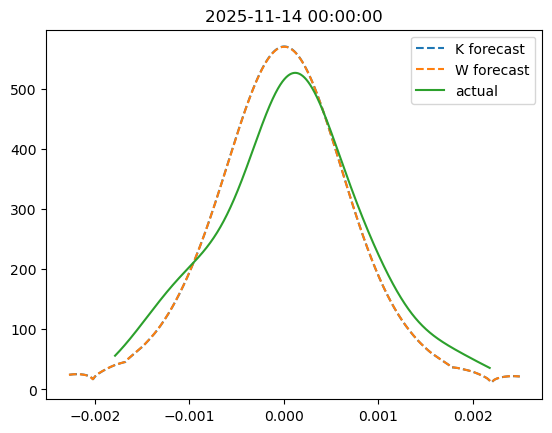

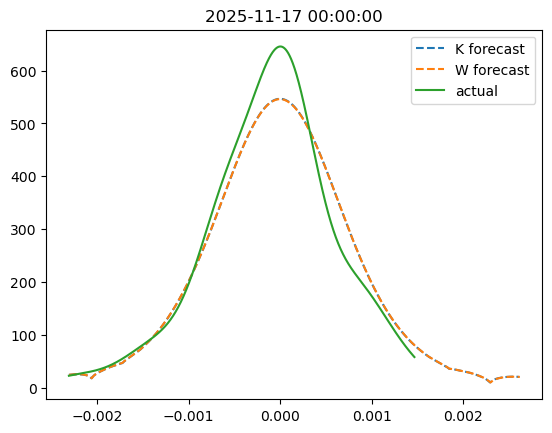

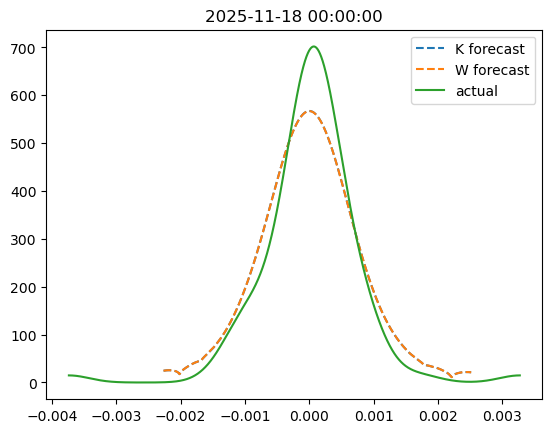

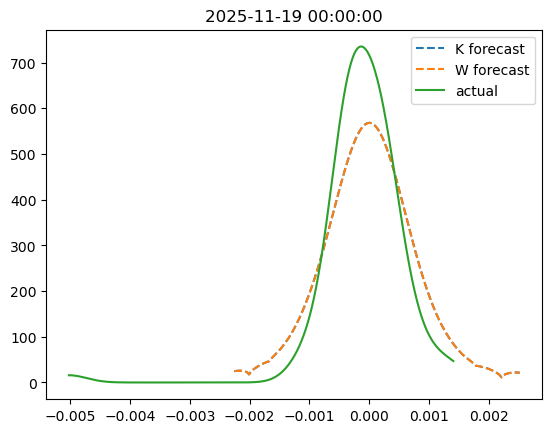

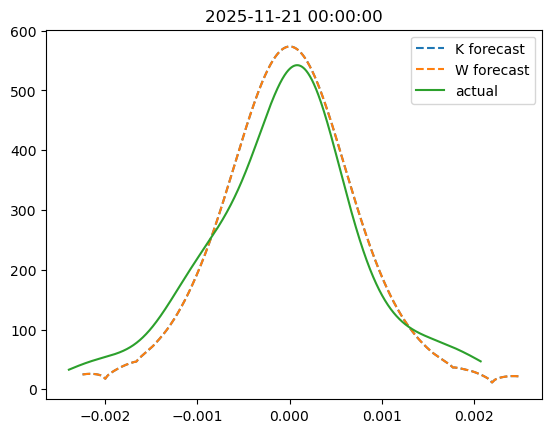

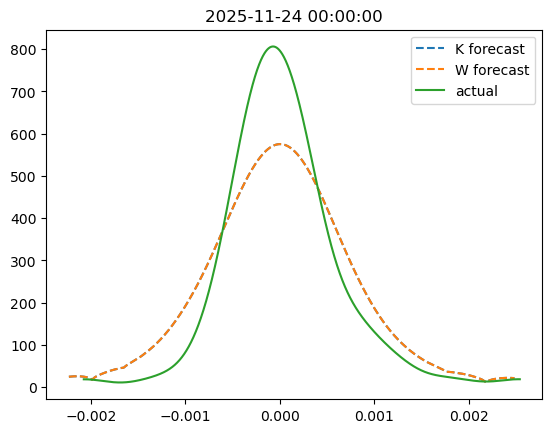

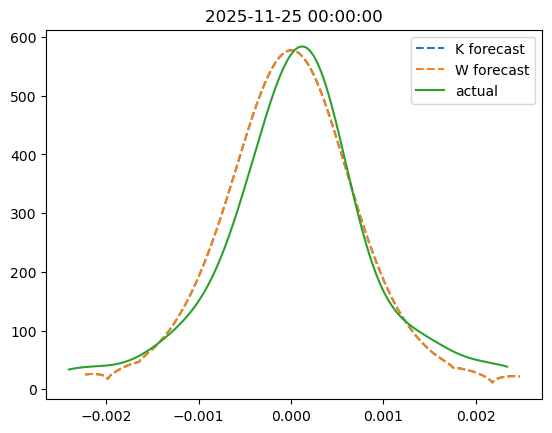

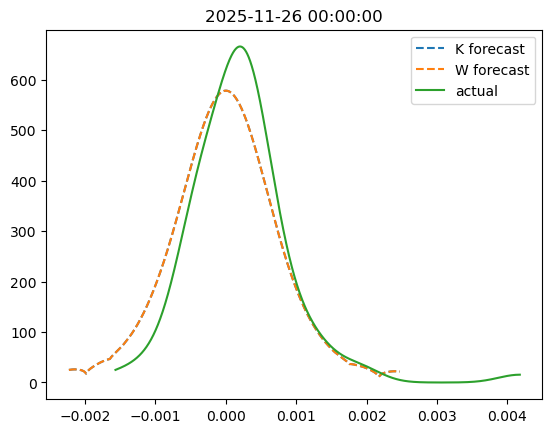

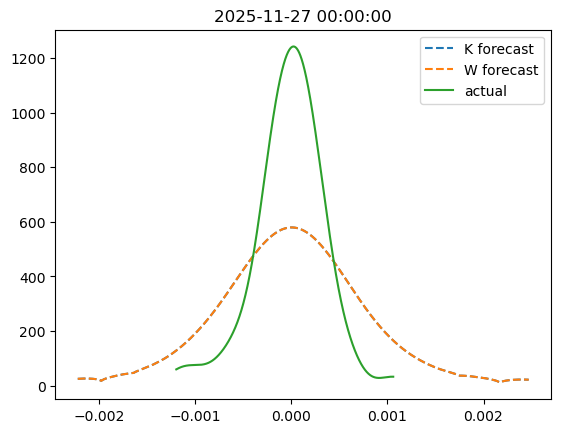

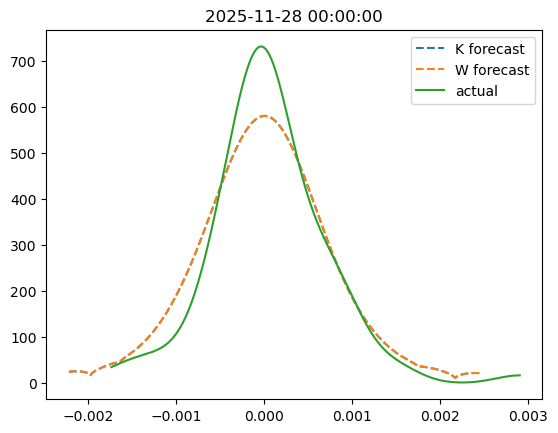

In [15]:
# Visualização
for t in range(horizon):
    col_name = Y_test.columns[t]

    test   = Y_test.loc[:,col_name]
    test_upp = Y_test_support.loc[:,col_name]
    k_t_fc = kle_bkw_densities.loc[:,col_name]
    k_t_fc_supp = kle_bkw_supports.loc[:,col_name]
    w_t_fc = wvlt_bkw_densities.loc[:,col_name]
    w_t_fc_supp = wvlt_bkw_supports.loc[:,col_name]

    plt.figure()

    plt.plot(k_t_fc_supp, k_t_fc, label="K forecast", linestyle="--")
    plt.plot(w_t_fc_supp, w_t_fc, label="W forecast", linestyle="--")
    plt.plot(test_upp, test, label="actual")

    plt.legend()
    plt.title(f"{col_name}")
    plt.plot()

In [16]:
df_supp, df_f_kle, df_kle_fhat = align_densities(
                                Y_test_support, 
                                Y_test, 
                                kle_bkw_supports, 
                                kle_bkw_densities, 
                                kle_bkw_densities.columns)

df_supp, df_f_wvlt, df_wlt_fhat = align_densities(
                                Y_test_support, 
                                Y_test, 
                                wvlt_bkw_supports, 
                                wvlt_bkw_densities, 
                                wvlt_bkw_densities.columns)

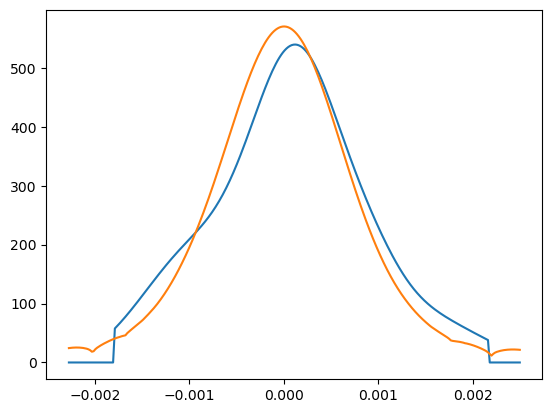

In [17]:
t=0

plt.figure()

plt.plot(df_supp.iloc[:,t], df_f_kle.iloc[:,t])
plt.plot(df_supp.iloc[:,t], df_kle_fhat.iloc[:,t])

plt.show()

In [18]:
print("KLE measures")
print(overall_measures(test=df_f_kle, forecast=df_kle_fhat))
print("\nWavelets measures")
print(overall_measures(test=df_f_wvlt, forecast=df_wlt_fhat))

KLE measures
{'KLD': np.float64(0.540653), 'JSD': np.float64(0.192525), 'Lnorm': np.float64(0.004092)}

Wavelets measures
{'KLD': np.float64(0.541349), 'JSD': np.float64(0.192632), 'Lnorm': np.float64(0.004092)}


In [19]:
msrs = overall_measures(test=df_f_kle, forecast=df_kle_fhat)

In [20]:
lista = []
lista.append(msrs)
lista.append(msrs)
lista.append(msrs)
lista

[{'KLD': np.float64(0.168186),
  'JSD': np.float64(0.189947),
  'Lnorm': np.float64(0.004046)},
 {'KLD': np.float64(0.168186),
  'JSD': np.float64(0.189947),
  'Lnorm': np.float64(0.004046)},
 {'KLD': np.float64(0.168186),
  'JSD': np.float64(0.189947),
  'Lnorm': np.float64(0.004046)}]

# Cross Validation

In [23]:
def workflow(Y, Y_support, horizon=1):
    windows = expanding_window_cv(df_densities.shape[1], h=horizon, initial_window=240)

    measures = []
    for fold, window in enumerate(windows):
        print(f"cv {fold}")
        idx_train = window[0]
        idx_test  = window[1]
        
        Y_train_support, Y_train = Y_support.iloc[:,idx_train], Y.iloc[:,idx_train]
        Y_test_support , Y_test = Y_support.iloc[:,idx_test],  Y.iloc[:,idx_test]

        bovespa_mLQDT = mLQDT(
                    Y_train,
                    Y_train_support
                )
        bovespa_mLQDT.densities_to_lqdensities(verbose=False)
        df_lqds = bovespa_mLQDT.lqd

        WdFPC_kwargs = {
            "wavelet": 'db2',
            "N": 3,
            "p": 5,
            "d": 2,
            "nt": M,
        }

        WdFPC_model = W_dFPC(df_lqds.values)
        WdFPC_model.fit(**WdFPC_kwargs)
        w_scores = WdFPC_model.scores.real.T

        KdFPC_kwargs = {
            "lag_max": 5,
            "alpha": 0.10,
            "du": 0.05,
            "B": 1000,
            "p": 5,
            "m": M,
            "u": bovespa_mLQDT.lqd_support,
            "select_ncomp": False,
            "dimension": 2
        }

        KdFPC_model = K_dFPC(df_lqds.values)
        KdFPC_model.fit(**KdFPC_kwargs)
        k_scores = KdFPC_model.etahat.real.T

        maxlags_  = 10
        criteria_ = 'bic'

        k_etahat_fc = run_forecaster(k_scores, maxlags_, criteria_, horizon)
        w_etahat_fc = run_forecaster(w_scores, maxlags_, criteria_, horizon)

        model = pm.auto_arima(
            bovespa_mLQDT.c,                         # univariate series
            seasonal=False,            # True if SARIMA
            trace=True,                # show the tried models
            error_action='ignore',     # ignore non-invertible models
            suppress_warnings=True,
            information_criterion='bic'
        )

        # Forecast h steps ahead
        c_forecast, conf_int = model.predict(n_periods=horizon, return_conf_int=True)

        k_curve_forecast = KdFPC_model.predict(k_etahat_fc)
        w_curve_forecast = WdFPC_model.predict(w_etahat_fc)

        df_k_forecast = pd.DataFrame(k_curve_forecast, columns=Y_test.columns)
        df_w_forecast = pd.DataFrame(w_curve_forecast, columns=Y_test.columns)

        kle_bkw_supports, kle_bkw_densities = obtain_densities_from_lqd(
                                                                    df_k_forecast,
                                                                    bovespa_mLQDT.lqd_support,
                                                                    c_forecast
                                                                    )

        wvlt_bkw_supports, wvlt_bkw_densities = obtain_densities_from_lqd(
                                                                    df_w_forecast,
                                                                    bovespa_mLQDT.lqd_support,
                                                                    c_forecast
                                                                    )
        
        df_supp, df_f_kle, df_kle_fhat = align_densities(
                                        Y_test_support, 
                                        Y_test, 
                                        kle_bkw_supports, 
                                        kle_bkw_densities, 
                                        kle_bkw_densities.columns)

        df_supp, df_f_wvlt, df_wlt_fhat = align_densities(
                                        Y_test_support, 
                                        Y_test, 
                                        wvlt_bkw_supports, 
                                        wvlt_bkw_densities, 
                                        wvlt_bkw_densities.columns)
        
        d1 = {
            "fold": fold,
            "method": "KLE",
        }
        d1.update(overall_measures(test=df_f_kle, forecast=df_kle_fhat))
        measures.append(d1)

        d2 = {
            "fold": fold,
            "method": "WLT",
        }
        d2.update(overall_measures(test=df_f_wvlt, forecast=df_wlt_fhat))
        measures.append(d2)

    return measures

In [24]:
cv_measures = workflow(df_densities, df_densities_supports)

cv 0


c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:613: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, m] = pywt.waverec(coeffs_m, wavelet)
c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:621: ComplexWarning: Casting complex values to real discards the imaginary part
  Yhat[:, t] = mu_hat + H @ scores[:, t]


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=354.491, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=83.240, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-841.930, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-828.778, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-836.729, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=-113.599, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-848.468, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-853.873, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-858.735, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-853.937, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.972 seconds
c not in lqdSup — resetting to closest v

c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:613: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, m] = pywt.waverec(coeffs_m, wavelet)
c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:621: ComplexWarning: Casting complex values to real discards the imaginary part
  Yhat[:, t] = mu_hat + H @ scores[:, t]


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=356.174, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=83.066, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-844.493, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-836.446, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-839.840, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=-112.443, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-851.692, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-856.708, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-861.428, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-856.793, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.164 seconds
c not in lqdSup — resetting to closest v

c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:613: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, m] = pywt.waverec(coeffs_m, wavelet)
c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:621: ComplexWarning: Casting complex values to real discards the imaginary part
  Yhat[:, t] = mu_hat + H @ scores[:, t]


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=357.512, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=83.406, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-848.585, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-839.936, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-843.988, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=-113.959, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-855.558, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-860.864, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-865.482, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-860.965, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.920 seconds
c not in lqdSup — resetting to closest v

c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:613: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, m] = pywt.waverec(coeffs_m, wavelet)
c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:621: ComplexWarning: Casting complex values to real discards the imaginary part
  Yhat[:, t] = mu_hat + H @ scores[:, t]


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=359.237, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=83.884, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-850.372, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-829.530, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-831.041, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=-111.794, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-857.362, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-862.980, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-867.484, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-863.112, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.775 seconds
c not in lqdSup — resetting to closest v

c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:613: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, m] = pywt.waverec(coeffs_m, wavelet)
c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:621: ComplexWarning: Casting complex values to real discards the imaginary part
  Yhat[:, t] = mu_hat + H @ scores[:, t]


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=360.740, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=83.898, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=inf, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=-113.180, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-850.402, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : BIC=-834.978, Time=0.20 sec
 ARIMA(0,0,3)(0,0,0)[0]             : BIC=-228.373, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-849.364, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0]             : BIC=inf, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=-860.015, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : BIC=-862.900, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-867.427, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-871.997, Time

c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:613: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, m] = pywt.waverec(coeffs_m, wavelet)
c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:621: ComplexWarning: Casting complex values to real discards the imaginary part
  Yhat[:, t] = mu_hat + H @ scores[:, t]


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=362.253, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=84.339, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=inf, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=-114.159, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-854.646, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : BIC=-845.593, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : BIC=-230.019, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-840.051, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[0]             : BIC=inf, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=-864.496, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : BIC=-867.409, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-871.881, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-876.471, Time

c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:613: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, m] = pywt.waverec(coeffs_m, wavelet)
c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:621: ComplexWarning: Casting complex values to real discards the imaginary part
  Yhat[:, t] = mu_hat + H @ scores[:, t]


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=363.551, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=84.086, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=inf, Time=0.31 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=-114.236, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-857.909, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : BIC=-851.462, Time=0.20 sec
 ARIMA(0,0,3)(0,0,0)[0]             : BIC=-232.037, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-850.180, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : BIC=inf, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=-867.722, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : BIC=-870.947, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-875.476, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-880.023, Time

c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:613: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, m] = pywt.waverec(coeffs_m, wavelet)
c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:621: ComplexWarning: Casting complex values to real discards the imaginary part
  Yhat[:, t] = mu_hat + H @ scores[:, t]


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=364.631, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=84.026, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-852.212, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-856.155, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : BIC=inf, Time=nan sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-856.074, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0]             : BIC=inf, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : BIC=inf, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=-863.157, Time=0.55 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-868.093, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-872.884, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-877.741, Time=0.03 sec
 

c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:613: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, m] = pywt.waverec(coeffs_m, wavelet)
c:\Users\mathe\Projetos\densities4risk\notebooks\..\src\libs\dynamicFPC.py:621: ComplexWarning: Casting complex values to real discards the imaginary part
  Yhat[:, t] = mu_hat + H @ scores[:, t]


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=366.075, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=84.421, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-865.445, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-845.383, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-860.635, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=-114.215, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-872.590, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-877.442, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-882.330, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-877.517, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.038 seconds
c not in lqdSup — resetting to closest v

In [30]:
df_measures = pd.DataFrame(cv_measures)
df_measures_long = df_measures.melt(
    id_vars="method",
    value_vars=["KLD", "JSD", "Lnorm"],
    var_name="metric",
    value_name="value"
)

In [ ]:
# df_measures.to_excel("../data/processed/cv_measures.xlsx", index=False)

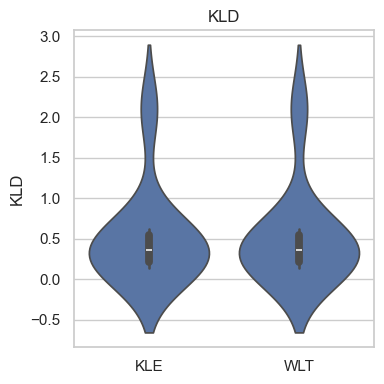

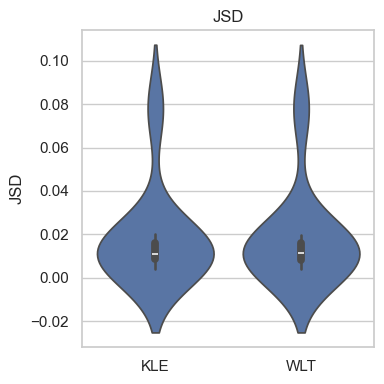

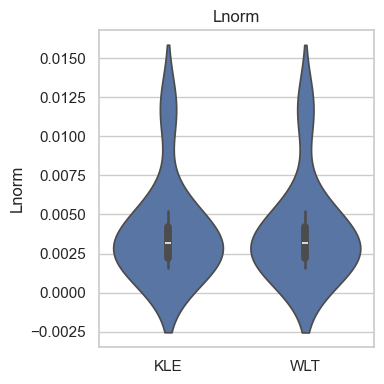

In [39]:
sns.set_theme(style="whitegrid")

measures = ["KLD", "JSD", "Lnorm"]

for m in measures:
    plt.figure(figsize=(4, 4))
    
    sns.violinplot(
        data=df_measures,
        x="method",
        y=m,
        inner="box"
    )
    
    plt.title(m)
    plt.xlabel("")
    plt.ylabel(m)
    plt.tight_layout()
    plt.show()

In [48]:
for measure in measures:
    print(f">Medida {measure}:")
    for method in df_measures["method"].unique():
        quantile = 0.5
        quantile_value = np.quantile(df_measures[df_measures.method == method][measure],quantile)
        print(f"\t Método {method}, quantil {quantile}: {quantile_value}")

>Medida KLD:
	 Método KLE, quantil 0.5: 0.359495
	 Método WLT, quantil 0.5: 0.359138
>Medida JSD:
	 Método KLE, quantil 0.5: 0.010973
	 Método WLT, quantil 0.5: 0.011197
>Medida Lnorm:
	 Método KLE, quantil 0.5: 0.003168
	 Método WLT, quantil 0.5: 0.003184
